# Exit Graph Control

* [Deeplearning.ai - AI Agents in LangGraph](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/m0x4m/essay-writer)

In [1]:
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from pydantic import (
    BaseModel,
    Field,
    ConfigDict,
    field_validator
)
from tavily import TavilyClient


memory = MemorySaver()

In [2]:
class AgentState(TypedDict):
    state: str
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [3]:
path_to_openai_key:str = os.path.expanduser('~/.openai/api_key')
with open(path_to_openai_key, 'r', encoding='utf-8') as file:
    os.environ["OPENAI_API_KEY"] = file.read().strip()

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [5]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [6]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [7]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [8]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [9]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [10]:
class Queries(BaseModel):
    queries: List[str]

In [11]:
path_to_tavily_key:str = os.path.expanduser('~/.tavily/api_key')
with open(path_to_tavily_key, 'r', encoding='utf-8') as file:
    os.environ["TAVILY_API_KEY"] = file.read().strip()

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [12]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [13]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state.get('content', [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [15]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [18]:
builder = StateGraph(AgentState)

In [19]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [20]:
builder.set_entry_point("planner")

In [21]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [22]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [23]:
graph = builder.compile(checkpointer=memory)

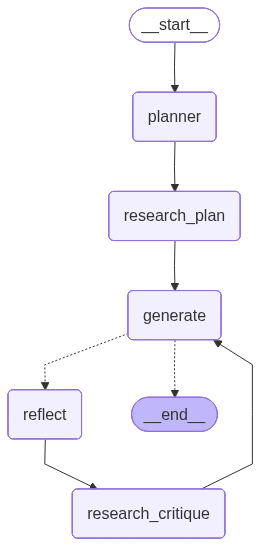

In [24]:
graph

In [25]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and applications\n    D. Advantages and limitations\n\nIII. Langsmith\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and applications\n    D. Advantages and limitations\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack and architecture\n    B. Scalability and performance\n    C. Security and privacy considerations\n    D. Community and adoption\n    E. Future outlook and potential developments\n\nV. Conclusion\n    A. Recap of key differences between Langchain and Langsmith\n    B. Implications for the blockchain and cryptocurrency industry\n    C. Final thoughts on the significance of these technologies\n\nNotes:\n- Ensure to provide clear defi

/Users/oonisim/venv/ml/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'research_plan': {'content': ['# LangChain vs LangSmith: A Developer-Focused Comparison. In LLM application development, LangChain and LangSmith have become central tools for building and managing large language model-powered solutions. This article compares LangChain and LangSmith, focusing on their core features, integration options, and value for developers in the LLM application space. LangChain is an open-source framework that helps developers create LLM applications efficiently. With LangChain, developers can quickly build chatbots, agents, and other AI applications with minimal boilerplate code. LangChain streamlines the development of conversational agents and tool-using AI. LangSmith provides tools to debug, monitor, and improve LLM-powered agents, and offers a managed cloud service with a web UI. | LLM Evaluation | Minimal built-in support; developers typically create custom logic or use external tools. LangChain provides building blocks for LLM applications, while LangSmith